In [101]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Loading the dataset
dataset = pd.read_csv('dataset.csv')

# Inferring the date format
dataset['acq_date'] = pd.to_datetime(dataset['acq_date'], errors='coerce', infer_datetime_format=True)

# Converting "acq_time" to string and handling the numbers stored as text
dataset['acq_time'] = dataset['acq_time'].astype(str).apply(lambda x: x.strip() if pd.notnull(x) else None)

# Extracting hour and minute from the 4-digit time format
dataset['acq_hour'] = dataset['acq_time'].str[:-2].apply(lambda x: int(x) if x.isdigit() else None)
dataset['acq_minute'] = dataset['acq_time'].str[-2:].apply(lambda x: int(x) if x.isdigit() else None)

# Combining 'acq_hour' and 'acq_minute' into a single 'acq_time' column
def combine_time(row):
    try:
        hour = int(row['acq_hour'])
        minute = int(row['acq_minute'])
        return pd.to_datetime(f'{hour:02d}:{minute:02d}', format='%H:%M').time()
    except (ValueError, TypeError):
        return pd.to_datetime('00:00', format='%H:%M').time()

dataset['acq_time'] = dataset.apply(combine_time, axis=1)

# Droping the intermediate columns used for extraction
dataset.drop(['acq_hour', 'acq_minute'], axis=1, inplace=True)

# Balanced Sampling
def balanced_sample(df, column_name, sample_size=3400):
    return df.groupby(column_name, group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size)))


balanced_subset = balanced_sample(dataset, 'type', sample_size=3400)

# Removng or feature reduction 'version' and 'instrument' columns
balanced_subset = balanced_subset.drop(['version', 'instrument'], axis=1)



# One-Hot Encoding
dataset_encoded = pd.get_dummies(balanced_subset, columns=['satellite', 'daynight'], drop_first=True)

# Scaling
numerical_columns = ['latitude', 'longitude', 'brightness', 'scan', 'track', 'bright_t31', 'frp']
scaler = MinMaxScaler()
dataset_encoded[numerical_columns] = scaler.fit_transform(dataset_encoded[numerical_columns])

# Display the updated dataset
print(dataset_encoded.head())

C:\Users\saeed\AppData\Local\Temp\ipykernel_9964\2184588654.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset['acq_date'] = pd.to_datetime(dataset['acq_date'], errors='coerce', infer_datetime_format=True)


         latitude  longitude  brightness      scan  track   acq_date  \
1593070  0.337034   0.567838    0.002908  0.078947    0.1 2018-06-19   
3709577  0.454256   0.574303    0.115366  0.578947    0.7 2018-11-16   
2987584  0.734562   0.197059    0.121667  0.078947    0.1 2018-09-12   
3621544  0.651134   0.711818    0.170625  0.026316    0.0 2018-11-08   
3899268  0.441935   0.531592    0.087736  0.026316    0.0 2018-12-05   

         acq_time  confidence  bright_t31       frp  type  satellite_Terra  \
1593070  20:40:00          30    0.165926  0.000872     0             True   
3709577  09:18:00          79    0.270370  0.007233     0             True   
2987584  18:20:00          73    0.254815  0.002798     0             True   
3621544  08:18:00          87    0.268148  0.003089     0            False   
3899268  12:49:00          50    0.269630  0.000915     0            False   

         daynight_N  
1593070        True  
3709577       False  
2987584       False  
3621544   

In [102]:
# Storing it as a cv

dataset_encoded.to_csv('preprocessed_dataset.csv', index=False)



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import Dropout

# Loading preprocessed dataset
data = pd.read_csv('preprocessed_dataset.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
data['daynight_N'] = label_encoder.fit_transform(data['daynight_N'])
data['satellite_Terra'] = label_encoder.fit_transform(data['satellite_Terra'])

# Define features and target variable
X = data.drop(['acq_date', 'acq_time', 'type'], axis=1)
y = data['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building the RNN model
model = Sequential()

# First LSTM layer with more units and a dropout layer for regularization
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with more units and a dropout layer
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with more units and no return sequences since it's the last LSTM layer
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

# Dense output layer with softmax activation for multiclass classification
model.add(Dense(4, activation='softmax'))

# Compiling the model
optimizer = Adam(learning_rate=0.010)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Model Accuracy: {accuracy * 100:.2f}%")



Epoch 1/50


272/272 [==============================] - 9s 10ms/step - loss: 1.0686 - accuracy: 0.5479 - val_loss: 0.8633 - val_accuracy: 0.6627
Epoch 2/50
272/272 [==============================] - 2s 7ms/step - loss: 0.8639 - accuracy: 0.6634 - val_loss: 0.7486 - val_accuracy: 0.7054
Epoch 3/50
272/272 [==============================] - 3s 10ms/step - loss: 0.7928 - accuracy: 0.6920 - val_loss: 0.7001 - val_accuracy: 0.7096
Epoch 4/50
272/272 [==============================] - 2s 8ms/step - loss: 0.7684 - accuracy: 0.7009 - val_loss: 0.6415 - val_accuracy: 0.7583
Epoch 5/50
272/272 [==============================] - 2s 9ms/step - loss: 0.7318 - accuracy: 0.7181 - val_loss: 0.6206 - val_accuracy: 0.7721
Epoch 6/50
272/272 [==============================] - 3s 12ms/step - loss: 0.7016 - accuracy: 0.7293 - val_loss: 0.5935 - val_accuracy: 0.7776
Epoch 7/50
272/272 [==============================] - 7s 27ms/step - loss: 0.6906 - accuracy: 0.7363 - val_loss: 0.5782 - val_accuracy: 0.778

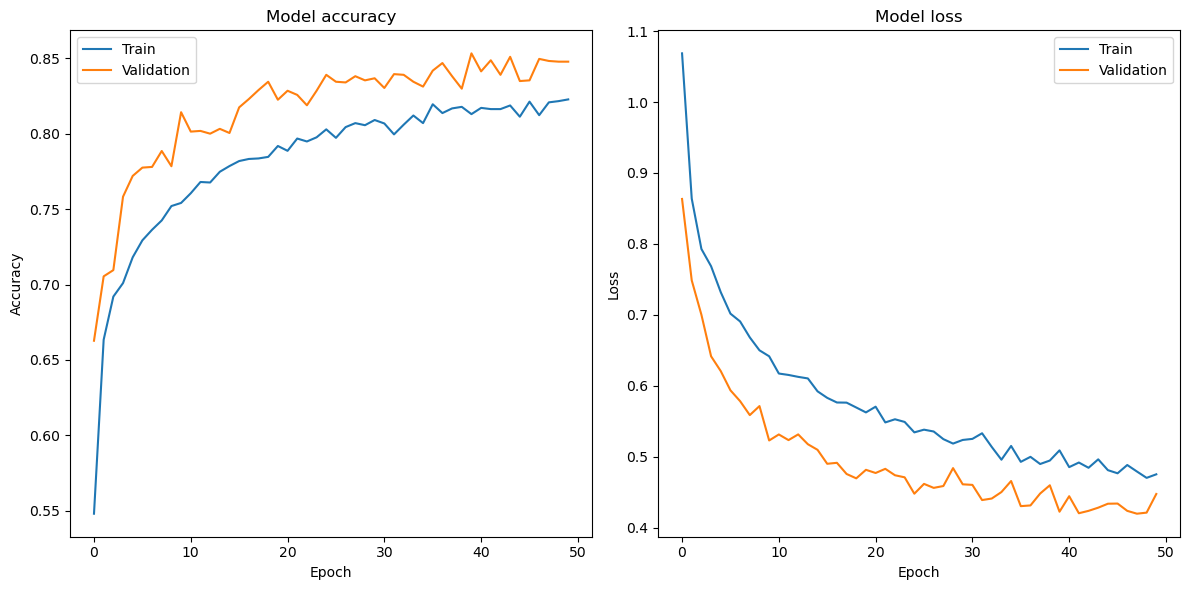

In [2]:
# Plotting accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [4]:
# Saving the model
model.save('wildfire_rnn.h5')

C:\Users\saeed\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# Testing the saved model in subset of a test dataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Loading preprocessed test dataset
test_data = pd.read_csv('preprocessed_dataset.csv')  

# Encoding categorical variables as in building the model 

test_data['daynight_N'] = label_encoder.transform(test_data['daynight_N'])
test_data['satellite_Terra'] = label_encoder.transform(test_data['satellite_Terra'])

# Randomly selecting a subset of the test data

subset_size = 200 
test_subset = test_data.sample(n=subset_size, random_state=42)

# Preparing features for prediction

X_test_subset = test_subset.drop(['acq_date', 'acq_time', 'type'], axis=1)
X_test_subset = scaler.transform(X_test_subset)  
X_test_subset = np.reshape(X_test_subset, (X_test_subset.shape[0], 1, X_test_subset.shape[1]))

# Loading the saved trained model
model = load_model('wildfire_rnn.h5')  

# Make predictions on the test data subset
predictions_subset = model.predict(X_test_subset)
y_true_subset = test_subset['type']
y_pred_subset = np.argmax(predictions_subset, axis=1)  

# Evaluate model performance on the subset
accuracy_subset = accuracy_score(y_true_subset, y_pred_subset)
print(f"Test Accuracy on Subset: {accuracy_subset * 100:.2f}%")

#classification metrics for the subset
print(classification_report(y_true_subset, y_pred_subset))



7/7 [==============================] - 1s 5ms/step
Test Accuracy on Subset: 87.50%
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        47
           1       0.96      0.95      0.95        55
           2       0.77      0.83      0.80        52
           3       0.91      0.93      0.92        46

    accuracy                           0.88       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.88      0.88      0.88       200

